In [17]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import tqdm

# proof that u can learn a lifting linearization decently well

In [325]:
# def cost_fn(x, u):
#     if isinstance(x, float):
#         x = torch.tensor([x])
#     if isinstance(u, float):
#         u = torch.tensor([u])
#     return (x ** 2).sum() + (u ** 2).sum()

def cost_fn(x, u):
    if isinstance(x, float):
        x = torch.tensor([x])
    if isinstance(u, float):
        u = torch.tensor([u])
    return torch.abs(x).sum() #+ torch.abs(u).sum()

class LDS:
    def __init__(self,
                 du,
                 ds):
        self.A = torch.randn((ds, ds))
        self.B = torch.randn((ds, du))
    
    def __call__(self, state, control):
        return self.A @ state + self.B @ control

In [ ]:
from collections import deque
from models import MLP

from deluca.agents._lqr import LQR

def _exponential_linspace_int(start, end, num, divisible_by=1):
    """Exponentially increasing values of integers."""
    base = np.exp(np.log(end / start) / (num - 1))
    return [int(np.round(start * base**i / divisible_by) * divisible_by) for i in range(num)]

class Lifter:
    def __init__(self,
                 h,
                 du,
                 lift_dim,
                 depth=12,
                 lr=0.004):
        self.h = h
        self.du = du
        self.lift_dim = lift_dim
        
        self.model = MLP(layer_dims=_exponential_linspace_int(self.h, self.lift_dim, depth), use_bias=False).train().float()
        self.A = torch.nn.Parameter(torch.zeros((self.lift_dim, self.lift_dim), dtype=torch.float32))
        self.B = torch.nn.Parameter(torch.zeros((self.lift_dim, self.du), dtype=torch.float32))
        self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.sysid_opt = torch.optim.Adam([self.A, self.B], lr=lr)
        
    def lift(self, history):
        out = self.model(history.unsqueeze(0)).squeeze()
        out = out / torch.linalg.norm(out)
        return out
    

ds = 1
h = 20
du = 6
lift_dim = 128
T = 4000
STEP_EVERY = 20

def disturbance(t):
    return np.sin(6 * t * 2 * np.pi / T)
#     return 1
#     return 0


def go(seed, step_l, step_a, ax):
    torch.manual_seed(seed)
    sys = LDS(du, ds)
    state = torch.randn(ds)
    control = torch.zeros(du)
    prev_lifted_state = torch.zeros(lift_dim)
    costs = deque([0. for _ in range(h)], maxlen=h)

    lqr = LQR(sys.A.data.numpy(), sys.B.data.numpy())
    l = Lifter(h, du, lift_dim, depth=3)

    ts = []
    losses = []
    As = []
    Bs = [] 
    preds = []
    gts = []
    for t in tqdm.trange(1, T + 1):
#         control = torch.from_numpy(np.array(lqr(state.detach().data.numpy()))).float()
        control = torch.randn(du) * 0.01
        state = sys(state, control) + disturbance(t) * torch.ones(ds)
        cost = cost_fn(state, control)
        costs.append(cost)

        history = torch.from_numpy(np.array(costs)).float()
        lifted_state = l.lift(history)
        pred_state = l.A @ prev_lifted_state + l.B @ control
        diff = lifted_state - pred_state

        l.opt.zero_grad()
        l.sysid_opt.zero_grad()
        loss = torch.mean(diff ** 2)
        loss.backward()
        if step_l: l.opt.step()
        if step_a: l.sysid_opt.step()
            
        prev_lifted_state = lifted_state.detach().clone()
        ts.append(t)
        losses.append(loss.item())
        As.append(l.A.data.numpy().copy())
        Bs.append(l.B.data.numpy().copy())
        preds.append(pred_state[0].item())
        gts.append(lifted_state[0].item())

    ts = np.array(ts)
    losses = np.array(losses)
    As = np.array(As)
    Bs = np.array(Bs)
    label = 'step_l:{}  step_a:{}'.format(step_l, step_a)
    print(label, losses[-int(0.1 * len(losses)):].mean())
    ax[0, 0].plot(ts, losses, label=label)
    ax[0, 1].plot(ts, preds, label=label + ' preds')
    ax[0, 1].plot(ts, gts, label=label + ' gts')
    ax[1, 0].plot(ts, As[:, 0, 0], label=label)
    ax[1, 1].plot(ts, Bs[:, 0, 0], label=label)
    # plt.fill_between(avgs, avgs - np.sqrt(vars), avgs + np.sqrt(vars))
#     plt.ylim((0, 2))

In [338]:
from collections import deque
from models import MLP

from deluca.agents._lqr import LQR

def _exponential_linspace_int(start, end, num, divisible_by=1):
    """Exponentially increasing values of integers."""
    base = np.exp(np.log(end / start) / (num - 1))
    return [int(np.round(start * base**i / divisible_by) * divisible_by) for i in range(num)]

class Lifter:
    def __init__(self,
                 h,
                 du,
                 lift_dim,
                 depth=12,
                 lr=0.004):
        self.h = h
        self.du = du
        self.lift_dim = lift_dim
        
        self.model = MLP(layer_dims=_exponential_linspace_int(self.h, self.lift_dim, depth), use_bias=False).train().float()
        self.A = torch.nn.Parameter(torch.zeros((self.lift_dim, self.lift_dim), dtype=torch.float32))
        self.B = torch.nn.Parameter(torch.zeros((self.lift_dim, self.du), dtype=torch.float32))
        self.opt = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.sysid_opt = torch.optim.Adam([self.A, self.B], lr=lr)
        
    def lift(self, history):
        out = self.model(history.unsqueeze(0)).squeeze()
        out = out / torch.linalg.norm(out)
        return out
    

ds = 1
h = 20
du = 6
lift_dim = 128
T = 4000
STEP_EVERY = 20

def disturbance(t):
    return np.sin(6 * t * 2 * np.pi / T)
#     return 1
#     return 0


def go(seed, step_l, step_a, ax):
    torch.manual_seed(seed)
    sys = LDS(du, ds)
    state = torch.randn(ds)
    control = torch.zeros(du)
    prev_lifted_state = torch.zeros(lift_dim)
    costs = deque([0. for _ in range(h)], maxlen=h)

    lqr = LQR(sys.A.data.numpy(), sys.B.data.numpy())
    l = Lifter(h, du, lift_dim, depth=3)

    ts = []
    losses = []
    As = []
    Bs = [] 
    preds = []
    gts = []
    for t in tqdm.trange(1, T + 1):
#         control = torch.from_numpy(np.array(lqr(state.detach().data.numpy()))).float()
        control = torch.randn(du) * 0.01
        state = sys(state, control) + disturbance(t) * torch.ones(ds)
        cost = cost_fn(state, control)
        costs.append(cost)

        history = torch.from_numpy(np.array(costs)).float()
        lifted_state = l.lift(history)
        pred_state = l.A @ prev_lifted_state + l.B @ control
        diff = lifted_state - pred_state

        l.opt.zero_grad()
        l.sysid_opt.zero_grad()
        loss = torch.mean(diff ** 2)
        loss.backward()
        if step_l: l.opt.step()
        if step_a: l.sysid_opt.step()
            
        prev_lifted_state = lifted_state.detach().clone()
        ts.append(t)
        losses.append(loss.item())
        As.append(l.A.data.numpy().copy())
        Bs.append(l.B.data.numpy().copy())
        preds.append(pred_state[0].item())
        gts.append(lifted_state[0].item())

    ts = np.array(ts)
    losses = np.array(losses)
    As = np.array(As)
    Bs = np.array(Bs)
    label = 'step_l:{}  step_a:{}'.format(step_l, step_a)
    print(label, losses[-int(0.1 * len(losses)):].mean())
    ax[0, 0].plot(ts, losses, label=label)
    ax[0, 1].plot(ts, preds, label=label + ' preds')
    ax[0, 1].plot(ts, gts, label=label + ' gts')
    ax[1, 0].plot(ts, As[:, 0, 0], label=label)
    ax[1, 1].plot(ts, Bs[:, 0, 0], label=label)
    # plt.fill_between(avgs, avgs - np.sqrt(vars), avgs + np.sqrt(vars))
#     plt.ylim((0, 2))

seed 670


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:06<00:00, 661.68it/s]


step_l:False  step_a:False 0.007812499941792339


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:06<00:00, 611.71it/s]


step_l:False  step_a:True 0.0008234234459791878


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:06<00:00, 645.90it/s]


step_l:True  step_a:False 0.0078125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 565.70it/s]


step_l:True  step_a:True 1.409731769470568e-05


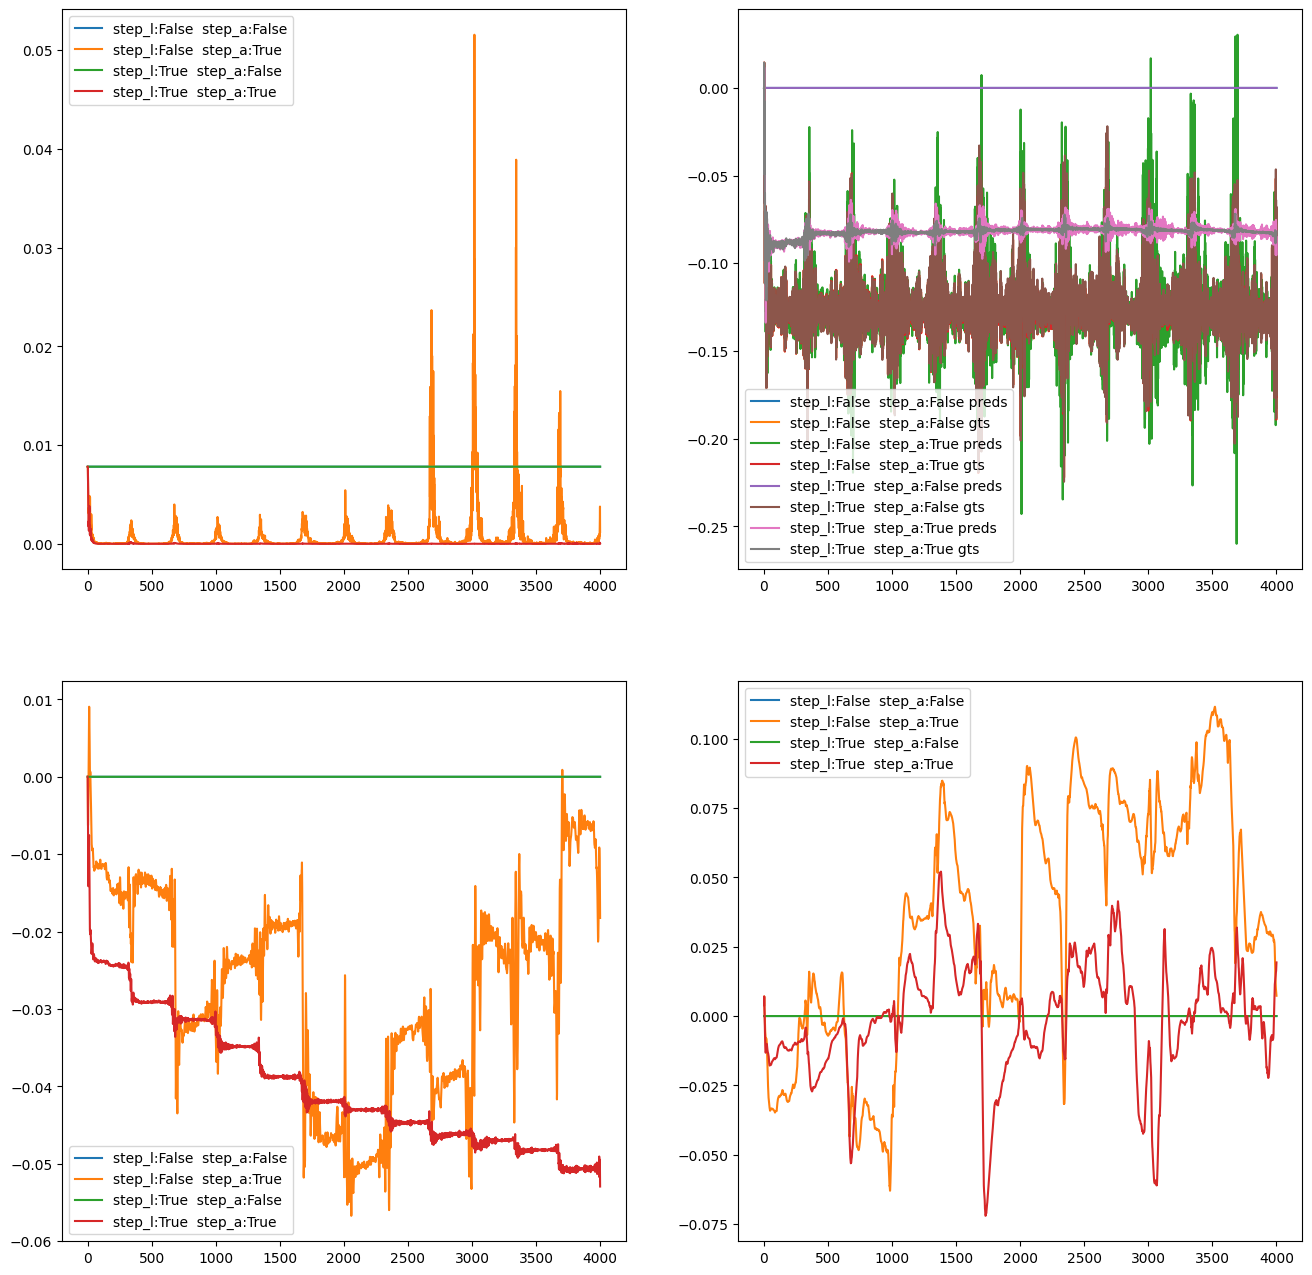

In [339]:
import matplotlib.pyplot as plt

seed = np.random.randint(2000)
print('seed', seed)

fig, ax = plt.subplots(2, 2, figsize=(16, 16))
go(step_a=False, step_l=False, seed=seed, ax=ax)
go(step_a=True, step_l=False, seed=seed, ax=ax)
go(step_a=False, step_l=True, seed=seed, ax=ax)
go(step_a=True, step_l=True, seed=seed, ax=ax)
ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

plt.show()

# proof that u can learn an inverse of an injective NN decently

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.15it/s]


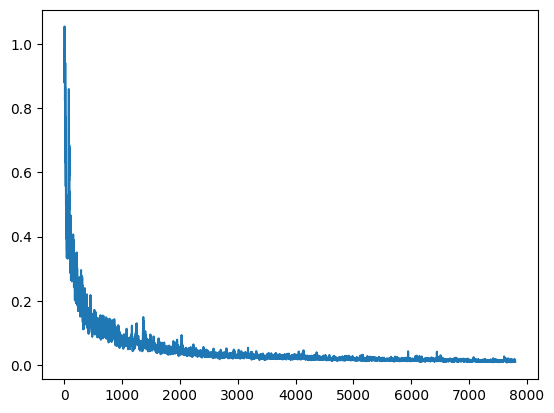

In [15]:
h = 5
dim = 200
num_epochs = 100
n_data = 5000
batch_size = 64
lr = 0.002

up = torch.nn.Sequential(torch.nn.Linear(h, dim), torch.nn.LeakyReLU(), torch.nn.Linear(dim, dim), torch.nn.LeakyReLU(), torch.nn.Linear(dim, dim)).train()
down = torch.nn.Sequential(torch.nn.Linear(dim, dim), torch.nn.LeakyReLU(), torch.nn.Linear(dim, dim), torch.nn.LeakyReLU(), torch.nn.Linear(dim, h)).train()

up_opt = torch.optim.Adam(up.parameters(), lr=lr)
down_opt = torch.optim.Adam(down.parameters(), lr=lr)


x = torch.randn((n_data, h))
y = torch.randn((n_data, dim))
dl = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True, drop_last=True)

losses = []
for _ in tqdm.trange(num_epochs):
    for _x, _y in dl:
        top = up(_x)

        up_opt.zero_grad()
        torch.nn.functional.mse_loss(_y, top).backward()
        up_opt.step()

        bottom = down(top.detach())
        down_opt.zero_grad()
        loss = torch.nn.functional.mse_loss(_x, bottom)
        loss.backward()
        down_opt.step()

        losses.append(loss.item())
    
    
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses)
plt.show()
    